In [ ]:
# Install all necessary libraries
!pip install pandas_datareader
!pip install yfinance
!pip install fix_yahoo_finance

In [ ]:
# Import Dependencies
from numpy.core.fromnumeric import mean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [ ]:
# Import the list of stock of portfolio and their weights
ETFsList = pd.read_csv("ETFsList.csv")
ETFsList=ETFsList['TICKER']
weights = pd.read_csv("ETFsList.csv")
weights = weights['WEIGHT']
weights=weights.to_numpy()
weights

array([0.03, 0.35, 0.18, 0.18, 0.18, 0.05, 0.03])

In [ ]:
# Define basic functions
def get_data(stocks, start, end):
  stockData = pdr.get_data_yahoo(stocks, start, end)
  stockData = stockData['Close']
  returns = stockData.pct_change(periods=1)
  returns_log = np.log(stockData/stockData.shift())
  return returns, returns_log, stockData

def mc_step1 (returns):
  meanReturns = returns.mean()
  covMatrix = returns.cov()
  return meanReturns, covMatrix

def mcVaR(returns, alpha=5):
  ## Input: panda Series of returns
  ## Output: percentile on return distribution a a certain confidence level

  if isinstance (returns, pd.Series):
    return np.percentile(returns,alpha)
  else:
    return TypeError("Expected a Pandas Data Series")

# Conditional Value at Risk gives the expected shortfall once we have crossed the confidence level

def mcCVaR(returns, alpha=5):
  ### Input: panda Series of returns
  ### Output: CVAR or Expected loss to a givencertain confidence level

  if isinstance (returns, pd.Series):
    belowVaR = returns <= mcVaR(returns, alpha=alpha)
    return returns[belowVaR].mean()
  else:
    return TypeError("Expected a Pandas Data Series")

def drawdown(returns):
    """Determines the drawdown

    Parameters
    ----------
    returns : pd.Series
        Daily returns of an asset, noncumulative

    Returns
    -------
    drawdown : pd.Series

    """

    # replace the first nan value with 0.0
    returns.fillna(0.0, inplace=True)

    # create cumulative returns
    cumulative = (returns + 1).cumprod()

    # np.maximum.accumulate takes the running max value
    # of the input series. in this case, it will maintain
    # the running maximum value. this is the running
    # maximum return
    running_max = np.maximum.accumulate(cumulative)

    # compute the change between the cumulative return
    # and the running maximum return
    return (cumulative - running_max) / running_max

In [ ]:
# Define our Monte Carlo Simulation Function

def mc_simulation (stockList, weights, timePeriod, timePeriod2, mc_sims, T, initialPortfolio, alpha):
  # Create our portfolio stock price data
  stocks = [stock for stock in stockList]
  endDate = dt.datetime.now()-dt.timedelta(days=timePeriod2)
  startDate = endDate - dt.timedelta(days=timePeriod)
  returns, returns_log, stockData = get_data(stocks, startDate, endDate)

  # COmpute mean returns and variance/covariance matrix
  meanReturns, covMatrix = mc_step1(returns)

  # Compute the simulation
  meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
  meanM = meanM.T

  portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

  for m in range(0,mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L,Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

  # Compute de Value at Risk and the Conditional Value at Risk
  portfolioResults = pd.Series(portfolio_sims[-1,:])
  VaR = (initialPortfolio - mcVaR(portfolioResults, alpha=5))/initialPortfolio*100
  CVaR = (initialPortfolio - mcCVaR(portfolioResults, alpha=5))/initialPortfolio*100
  return stockData, portfolio_sims, VaR, CVaR


[*********************100%***********************]  7 of 7 completed
VaR 2.98%
CVaR 16.29%


Text(0.5, 1.0, 'Monte Carlo Simulation of Best Performing ETFs by Asset Class Portfolio')

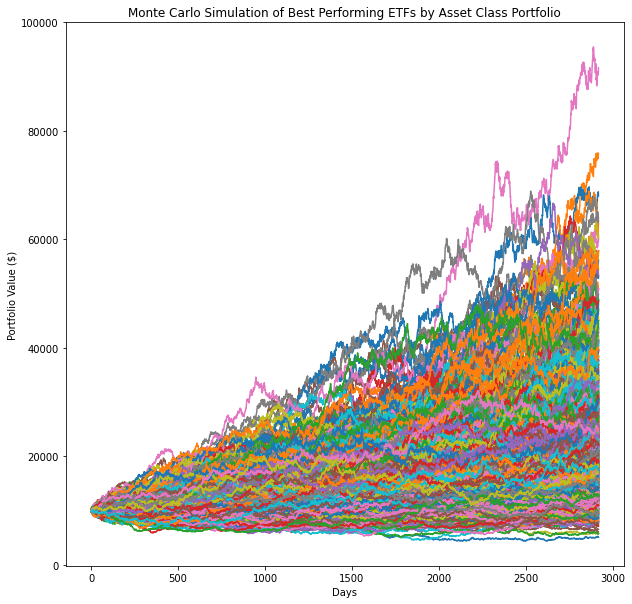

In [ ]:
timePeriod = 7*365
timePeriod2 = 8*365
stockList = ETFsList
weights = weights
mc_sims = 1000
T = 8*365 # timeframe in days
initialPortfolio = 10000
alpha=5
stockData, portfolio_sims, VaR, CVaR = mc_simulation(stockList, weights, timePeriod, timePeriod2, mc_sims, T, initialPortfolio, alpha)
print('VaR {}%'.format(round(VaR,2)))
print('CVaR {}%'.format(round(CVaR,2)))
plt.figure(figsize=(10,10))
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('Monte Carlo Simulation of Best Performing ETFs by Asset Class Portfolio')

In [ ]:
stockData

,BIL,GLD,LQD,QQQ,SPY,VIG,VNQ
Date,,,,,,,
2007-08-24,91.940002,66.110001,104.279999,48.200001,148.330002,56.320000,69.169998
2007-08-27,91.820000,65.980003,104.000000,47.880001,146.949997,55.919998,67.669998
2007-08-28,91.919998,65.589996,104.889999,46.740002,143.720001,54.880001,65.599998
2007-08-29,91.980003,66.070000,104.410004,48.080002,146.539993,55.669998,68.000000
2007-08-30,92.000000,65.800003,104.720001,48.330002,146.149994,55.639999,68.349998
...,...,...,...,...,...,...,...
2015-02-13,91.459999,117.980003,120.830002,106.910004,209.779999,82.389999,85.059998
2015-02-17,91.459999,116.010002,120.269997,107.010002,210.110001,82.500000,84.849998
2015-02-18,91.459999,116.339996,120.699997,107.160004,210.130005,82.570000,85.639999


In [ ]:
df = pd.DataFrame(portfolio_sims)
df.loc[8*365-1].describe()

count     1000.000000
mean     22514.878935
std      10584.298061
min       5090.002786
25%      14997.586184
50%      20406.529966
75%      27301.981728
max      91589.141131
Name: 2919, dtype: float64

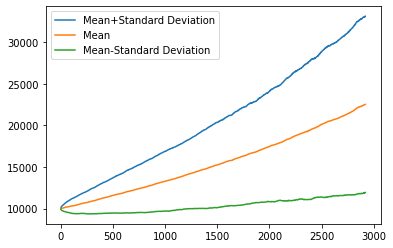

In [ ]:
df['mean']=df.mean(axis=1)
df['std']=df.std(axis=1)
df['mean+std']=df['mean']+df['std']
df['mean-std']=df['mean']-df['std']
plt.plot(df['mean+std'], label='Mean+Standard Deviation')
plt.plot(df['mean'], label='Mean')
plt.plot(df['mean-std'], label='Mean-Standard Deviation')
plt.legend(loc='best')

In [ ]:
df1=(df.loc[8*365-1]/initialPortfolio)**(1/(10))-1
df1.describe()

count    1004.000000
mean        0.074838
std         0.047842
min        -0.065301
25%         0.041322
50%         0.073932
75%         0.105654
max         0.247913
Name: 2919, dtype: float64

In [ ]:
stocks = [stock for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=timePeriod2)
returns2, returns_log2, stockData2 = get_data(stocks, startDate, endDate)

[*********************100%***********************]  7 of 7 completed


In [ ]:
stockData2

,BIL,GLD,LQD,QQQ,SPY,VIG,VNQ
Date,,,,,,,
2015-02-20,91.440002,115.279999,120.860001,108.410004,211.240005,82.839996,84.610001
2015-02-23,91.459999,115.430000,121.269997,108.519997,211.210007,82.730003,85.290001
2015-02-24,91.440002,115.260002,122.059998,108.599998,211.809998,83.040001,83.610001
2015-02-25,91.459999,115.699997,122.169998,108.330002,211.630005,82.980003,83.629997
2015-02-26,91.440002,116.070000,121.510002,108.879997,211.380005,82.879997,82.720001
...,...,...,...,...,...,...,...
2023-02-13,91.540001,172.479996,108.160004,304.500000,412.829987,157.169998,90.760002
2023-02-14,91.540001,172.610001,107.889999,306.750000,412.640015,156.490005,90.040001
2023-02-15,91.559998,170.889999,107.480003,309.100006,413.980011,157.050003,90.400002


In [ ]:
y = pd.DataFrame(index=stockData2.index)
y=y.reset_index()
y=y.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
y

,Date
14,2015-03-12
15,2015-03-13
16,2015-03-16
17,2015-03-17
18,2015-03-18
...,...
2009,2023-02-13
2010,2023-02-14
2011,2023-02-15
2012,2023-02-16


In [ ]:
df1=returns2.dot(weights)
cum_returns=((1+df1).cumprod())*initialPortfolio
df2=cum_returns.reset_index(drop=True)
df2=df2.reset_index(drop=True)


In [ ]:
df2=df2.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13])

Text(0.5, 1.0, 'Realized Returns & Mean-Stardard Deviation Distribution \nof a MonteCarlo Simulation of the Same Portfolio')

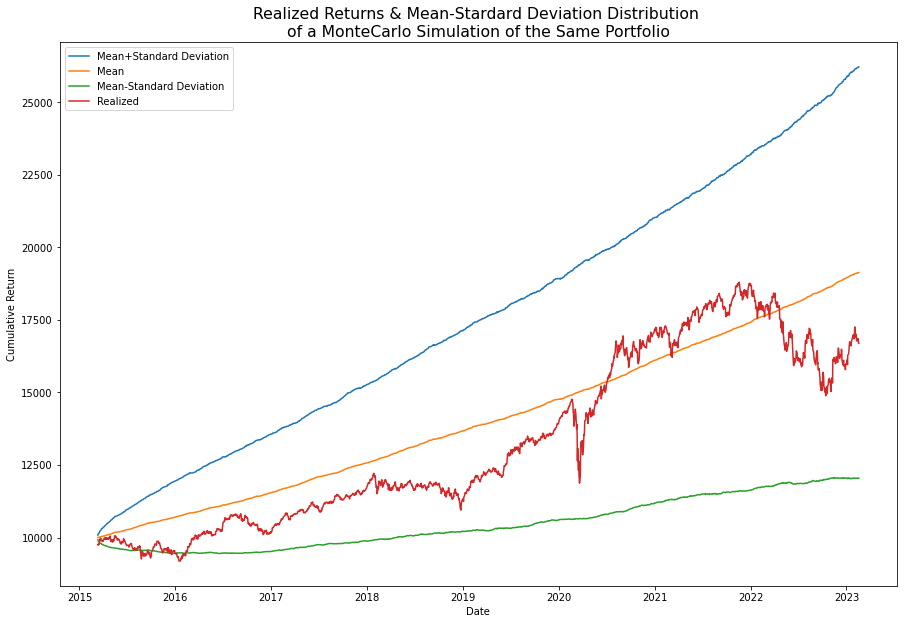

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(y['Date'], df['mean+std'], label='Mean+Standard Deviation')
plt.plot(y['Date'], df['mean'], label='Mean')
plt.plot(y['Date'], df['mean-std'], label='Mean-Standard Deviation')
plt.plot(y['Date'], df2, label ='Realized')
plt.legend(loc='best')
plt.rcParams.update({'font.size': 13})
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.title('Realized Returns & Mean-Stardard Deviation Distribution \nof a MonteCarlo Simulation of the Same Portfolio')

In [ ]:
stocks = 'SPY'
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=timePeriod2)
returns3, returns_log3, stockData3 = get_data(stocks, startDate, endDate)

[*********************100%***********************]  1 of 1 completed


In [ ]:
df1_1=returns3
cum_returns3=((1+df1_1).cumprod())*initialPortfolio
df3=cum_returns3.reset_index(drop=True)
df3=df3.reset_index(drop=True)
df3=df3.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13])

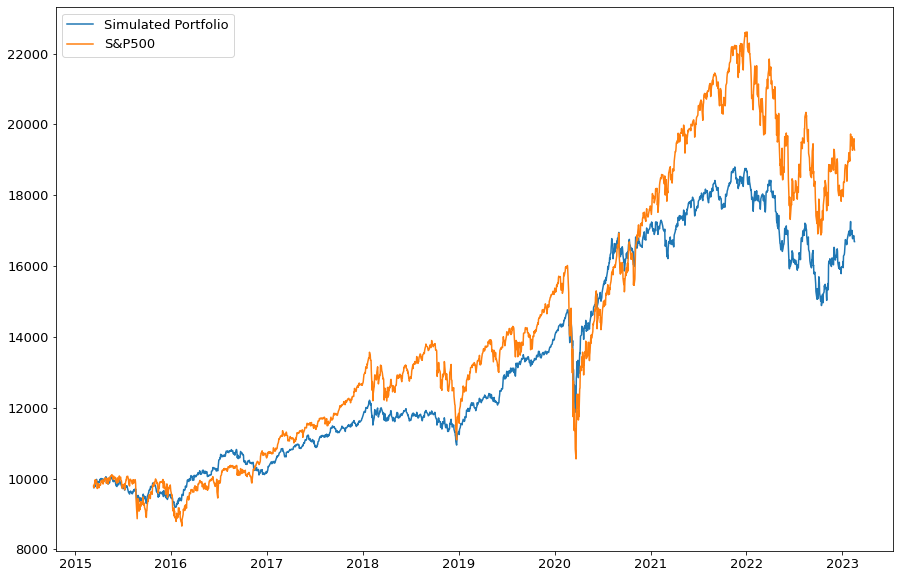

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(y['Date'], df2, label='Simulated Portfolio')
plt.plot(y['Date'], df3, label='S&P500')
plt.legend(loc='best')

Text(0.5, 1.0, 'S&P500 and Portfolio Drawdowns')

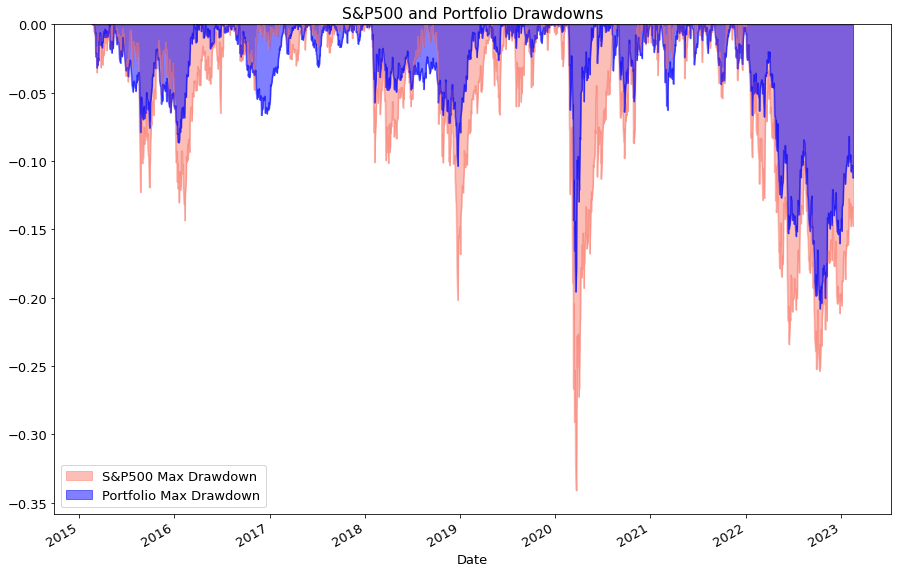

In [ ]:
plt.figure(figsize=(15,10))
drawdown(returns3).plot(kind="area", color="salmon", alpha=0.5, label='S&P500 Max Drawdown')
drawdown(df1).plot(kind="area", color="blue", alpha=0.5, label='Portfolio Max Drawdown')
plt.legend(loc='best')
plt.title('S&P500 and Portfolio Drawdowns')

In [ ]:
# Import the list of stock of portfolio and their weights
eqPortfolio = pd.read_csv("ETFsList_eq_weights.csv")
ETFsList=eqPortfolio['TICKER']
eqWeights = pd.read_csv("ETFsList_eq_weights.csv")
eqWeights = eqWeights['WEIGHT']
eqWeights=eqWeights.to_numpy()
eqWeights

array([0.05      , 0.15833333, 0.15833333, 0.15833333, 0.15833333,
       0.15833333, 0.15833333])

In [ ]:
df5=returns2.dot(eqWeights)
cum_returns2=((1+df5).cumprod())*initialPortfolio
df5=cum_returns2.reset_index(drop=True)
df5=df5.reset_index(drop=True)


In [ ]:
df5=df5.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13])

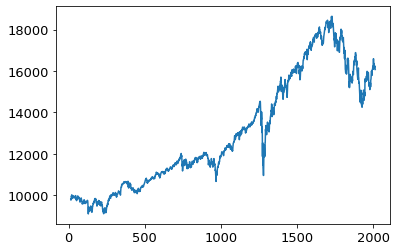

In [ ]:
df5.plot()

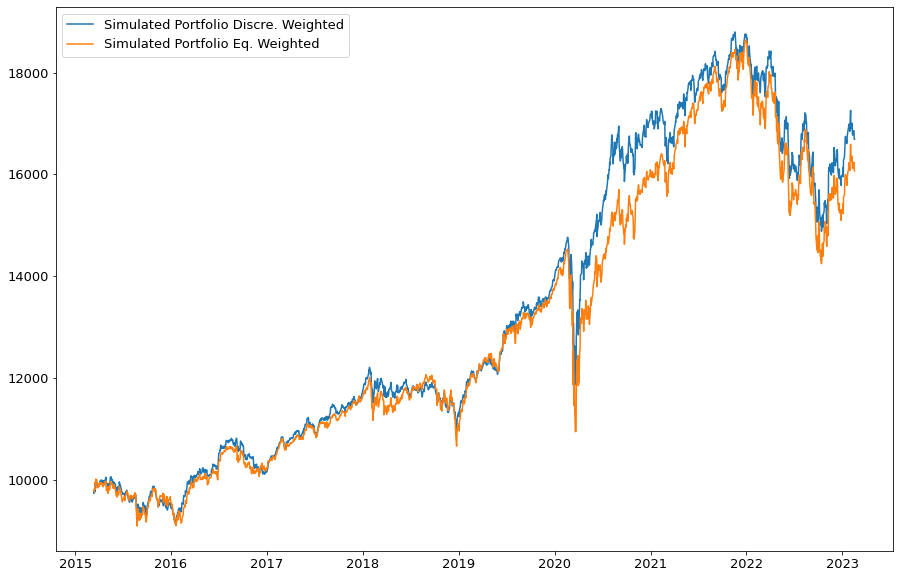

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(y['Date'], df2, label='Simulated Portfolio Discre. Weighted')
plt.plot(y['Date'], df5, label='Simulated Portfolio Eq. Weighted')
plt.legend(loc='best')